## Data pull from ADS
Focusing in on 50 most highly cited astronomy papers from the last 5 years

In [1]:
import networkx as nx
import os
import ads as ads 
import matplotlib.pyplot as plt
import pandas as pd
from networkx.algorithms import bipartite as bi

In [2]:
os.environ["ADS_DEV_KEY"] = "kNUoTurJ5TXV9hsw9KQN1k8wH4U0D7Oy0CJoOvyw"

In [3]:
ads.config.token = 'ADS_DEV_KEY' 

In [4]:
#Search for papers 
# 50 most cited papers recent papers
papers1 = list(ads.SearchQuery(q="*",
                               sort="citation_count desc",
                               year="2012, 2013, 2014, 2015, 2016, 2017",
                               rows=50 ))

In [6]:
# find author names
a = []
for i in papers1:
    authors1 = i.author
    a.append(authors1)
author_names = a

In [8]:
# find the journals
j = []
for i in papers1:
    journals1 = i.pub
    j.append(journals1)
journals = j

In [10]:
# find year of publication
y = []
for i in papers1:
    year1 = i.year
    y.append(year1)
year = y

In [12]:
# find titles
t = []
for i in papers1:
    title1 = i.title
    t.append(title1)
title = t

In [14]:
# find keywords
k = []
for i in papers1:
    keyword1 = i.keyword
    k.append(keyword1)
keyword = k

In [15]:
# create an initial df
df = pd.DataFrame({'Author_Names' : author_names,
                   'Journal':journals,
                   'Year':year,
                   'Title':title,
                   'Keyword':keyword
  })

In [16]:
# Expand the df with melt
s1 = df.apply(lambda x: pd.Series(x['Author_Names']),axis=1).stack().reset_index(level=1, drop=True)
s1.name = 'Author_Name'
s2 = df.apply(lambda x: pd.Series(x['Title']),axis=1).stack().reset_index(level=1, drop=True)
s2.name = 'Title'
s3 = df.apply(lambda x: pd.Series(x['Keyword']),axis=1).stack().reset_index(level=1, drop=True)
s3.name = 'Keyword'
df_m = df.drop(['Author_Names','Title', 'Keyword'], axis=1).join(s1)
df_m = df_m.join(s2)
df_m = df_m.join(s3)

print df_m.shape

(34780, 5)


In [17]:
df_m.to_csv('top_50.csv', sep=',', encoding='utf-8')

In [18]:
G=nx.from_pandas_dataframe(df_m, 'Journal', 'Author_Name', ['Title', 'Year', 'Keyword'])

In [19]:
# Weighted Projections/Clustering
# Largest most connected graph - 200 cut-off 
big_subg = [i for i in nx.connected_component_subgraphs(G) if len(i) > 200]
# Largest:
sg_largest = big_subg[0] # largest connected subgraph

# weighted_projections applied to subgraph to separate the two components
Journals,Author_Names = bi.sets(sg_largest)  # split into bipartites
j_proj_sg_largest = bi.weighted_projected_graph(sg_largest, Journals) 
a_proj_sg_largest = bi.weighted_projected_graph(sg_largest, Author_Names)

j = j_proj_sg_largest.edges(data=True) 
a = a_proj_sg_largest.edges(data=True)

In [20]:
# Island Method 
def trim(g):
    g_temp = nx.Graph()
    edge_bunch = [i for i in g.edges(data=True)]    
    g_temp.add_edges_from(edge_bunch)
    return g_temp
a_sg_island =  trim(a_proj_sg_largest)
j_sg_island = trim(j_proj_sg_largest)


In [21]:
#centrality
a_degree = nx.degree_centrality(a_sg_island)
j_degree = nx.degree_centrality(j_sg_island)

In [22]:
print a_sg_island.number_of_nodes()
print j_sg_island.number_of_nodes()

12
7268


In [23]:
print len(a_degree) # 12 journals
a_degree

12


{u'ArXiv e-prints': 0.2727272727272727,
 u'European Physical Journal C': 0.09090909090909091,
 u'Nature': 0.18181818181818182,
 u'Nature Nanotechnology': 0.09090909090909091,
 u'Nature Photonics': 0.18181818181818182,
 u'Physical Review D': 0.2727272727272727,
 u'Physical Review Letters': 0.7272727272727273,
 u'Physics Letters B': 0.5454545454545454,
 u'Science': 0.2727272727272727,
 u'Solar Physics': 0.18181818181818182,
 u'The Astrophysical Journal': 0.18181818181818182,
 u'The Astrophysical Journal Supplement Series': 0.09090909090909091}

In [24]:
len(j_degree) # 7268 authors

7268

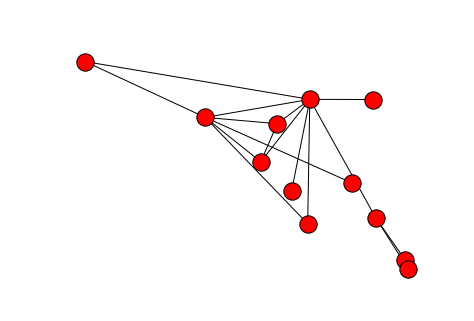

In [25]:
%matplotlib inline
nx.draw(a_sg_island,pos=nx.spring_layout(G)) # use spring layout